In [1]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 
import queue 

In [2]:
label_encoder = None 

def get_np_array(file_name):
    global label_encoder
    label_encoder = None
    data = pd.read_csv(file_name)
    
    need_label_encoding = ['team','host','opp','month', 'day_match']
    if(label_encoder is None):
        label_encoder = OrdinalEncoder()
        label_encoder.fit(data[need_label_encoding])
    mapping = label_encoder.categories_ # list of arrays
    data_1 = pd.DataFrame(label_encoder.transform(data[need_label_encoding]), columns = label_encoder.get_feature_names_out())
    
    #merge the two dataframes
    dont_need_label_encoding =  ["year","toss","bat_first","format" ,"fow","score" ,"rpo" ,"result"]
    data_2 = data[dont_need_label_encoding]
    final_data = pd.concat([data_1, data_2], axis=1)
    
    X = final_data.iloc[:,:-1]
    y = final_data.iloc[:,-1:]
    v1 = X.to_numpy()
    v2 = y.to_numpy()
    return (v1,v2, mapping)


In [3]:
X_train, Y_train, train_mapping = get_np_array("../data/train.csv") 
X_test, Y_test, test_mapping = get_np_array("../data/test.csv") 
# print((test_mapping)) 
to_extend = [ np.array([], dtype="int64"), np.array([0,1], dtype="int64"), np.array([0,1], dtype="int64"), 
             np.array([0,1], dtype="int64"), np.array([], dtype="int64"), np.array([], dtype="int64"), 
             np.array([], dtype="int64")]
train_mapping.extend( to_extend )
test_mapping.extend(to_extend) 
# print((test_mapping)) 
print((test_mapping)) 
print((train_mapping))

[array(['afganistan', 'australia', 'bangladesh', 'bermuda', 'canada',
       'england', 'india', 'ireland', 'kenya', 'netherlands',
       'new_zealand', 'pakistan', 'scotland', 'south_africa', 'sri_lanka',
       'uae', 'usa', 'west_indis', 'zimbambave'], dtype=object), array(['australia', 'bangladesh', 'bermuda', 'canada', 'england', 'india',
       'ireland', 'kenya', 'malaysia', 'netherlands', 'new_zealand',
       'pakistan', 'scotland', 'south_africa', 'sri_lanka', 'uae', 'usa',
       'west_indis', 'zimbambave'], dtype=object), array(['afganistan', 'australia', 'bangladesh', 'bermuda', 'canada',
       'england', 'india', 'ireland', 'kenya', 'netherlands',
       'new_zealand', 'pakistan', 'scotland', 'south_africa', 'sri_lanka',
       'uae', 'usa', 'west_indis', 'zimbambave'], dtype=object), array(['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may',
       'nov', 'oct', 'sep'], dtype=object), array([0, 1, 2], dtype=int64), array([], dtype=int64), array([0, 1], dtype

In [4]:
class DTNode:

    def __init__(self, depth, features, labels, is_leaf = False, value = 0, column = None):

        #to split on column
        self.depth = depth
        self.features = features
        self.labels = labels
        #add children afterwards
        self.children = None 
        # dict to get child idx from attribute value 
        self.get_idx = dict()

        #if leaf then also need value
        self.is_leaf = is_leaf
        if(self.is_leaf):
            self.value = value
        
        if(not self.is_leaf):
            self.column = column
        
        # valid only for cont attr
        self.median = None 
        
        # print(f"made new node with {features.shape[0]} data entries, and depth {depth}") 

def transform(x) : return x*math.log2(x)  

In [5]:
class DTTree:

    def __init__(self):
        #Tree root should be DTNode
        self.root = None      
        self.no_of_nodes = 0  

    def fit(self, X, y, types, mapping, max_depth = 10):
        self.type = types
        # self.x = self.convert_to_int(X)  
        self.x = X 
        self.y = y[:, 0]  # each element of y is a list 
        # print("y is ", self.y) 
        self.mapping = mapping 
        self.max_depth = max_depth

        self.root = self.grow_tree(self.x, self.y, 0) 
        self.no_of_nodes = self.count_nodes(self.root) 
        print("training complete") 

    def find_entropy(self, features, labels): # finds H[labels] 
        counts = np.unique(labels, return_counts=True)[1] 
        # print(counts) 
        if (counts.shape[0] == 0): print("empty labels array")  
        counts = counts / (labels.shape[0]) 
        entropy =  -1 * np.sum(np.vectorize(transform)(counts)) 
        return entropy 

    def find_conditional_entropy(self, features, labels, attribute): # finds H[labels | attribute] 
        # speed this up afterwards
        entropy = 0 
        total_size = features.shape[0]
        split_domain = [] 
        if (self.type[attribute] == "cat"):
            attribute_vals = np.unique(features[:, attribute])
            # print(f"for attribute {attribute} values are {attribute_vals}")  
            # no_of_attribute_vals = no_of_attribute_vals.shape[0] 
            for i in attribute_vals:
                new_features = features[features[:, attribute] == i] 
                new_labels = labels[features[:, attribute] == i]
                split_domain.append((i, new_features, new_labels)) 
                size = new_features.shape[0] 
                # print(f"attribute is {attribute}, value is {i} ", end=" ") 
                entropy += (size/total_size) * self.find_entropy(new_features, new_labels) 
        
        else:
            sorted_indices = np.argsort(features[:, attribute]) 
            # print("sorted array is ", features[sorted_indices, attribute]) 
            split_idx = (features.shape[0] - 1)//2 
            median_val = (features[sorted_indices])[split_idx, attribute]  
            # feature_1 = (features[sorted_indices])[: split_idx + 1] 
            # labels_1 = (labels[sorted_indices])[:split_idx + 1] 

            # feature_2 = (features[sorted_indices])[split_idx + 1:] 
            # labels_2 = (labels[sorted_indices])[split_idx + 1:] 

            feature_1 = features[features[:, attribute] <= median_val] 
            labels_1 = labels[features[:, attribute] <= median_val] 

            feature_2 = features[features[:, attribute] > median_val]
            labels_2 = labels[features[:, attribute] > median_val]  

            # print("median is ", median_val) 
            # print(feature_1[:, attribute])
            # print(feature_2[:, attribute])

            if (feature_1.shape[0] > 0) : 
                split_domain.append((median_val, feature_1, labels_1)) 
                entropy += (feature_1.shape[0]/total_size) * self.find_entropy(feature_1, labels_1)
            if (feature_2.shape[0] > 0):
                split_domain.append((median_val, feature_2, labels_2)) 
                entropy += (feature_2.shape[0]/total_size) * self.find_entropy(feature_2, labels_2)
            # print(f"attribute is {attribute}, median is {median_val} ", end=" ")

        
        
        return (entropy, split_domain)   

    def find_split_attribute(self, features, labels):
        max_gain = -1 
        split_attribute = None 
        init_entropy = self.find_entropy(features, labels)
        split_domain = None
        if (len(features.shape) < 2): print("invalid shape found ", features)
        for attribute in range(features.shape[1]):
            conditional_entropy, split = self.find_conditional_entropy(features, labels, attribute) 
            gain = init_entropy - conditional_entropy 
            if (gain > max_gain ): # case of equality and max_gain = 0 
                max_gain = gain 
                split_attribute = attribute 
                split_domain = split 
        return (split_attribute, split_domain) 
    
    def grow_tree(self, features, labels, depth): # returns a DTNode 
        node = DTNode(depth, features, labels)  
        # set is_leaf, value, column 

        y_count = np.unique(labels).shape[0] 
        if (y_count == 1):
            # terminate 
            # print("terminating coz all y same")
            node.is_leaf = True 
            node.value = self.leaf_prediction(node)  
            return node 
        
        if (depth == self.max_depth):
            # terminate 
            # print("terminating coz of depth")
            node.is_leaf = True 
            node.value = self.leaf_prediction(node)
            return node 
        
        
        # else build tree 
        # find attribute first 
        attribute, split_domain = self.find_split_attribute(features, labels)
        
        if (split_domain == None or len(split_domain) == 1):
            # terminate 
            node.is_leaf = True 
            node.value = self.leaf_prediction(node) 
            return node 

        # print("split on ", attribute)
        # print()
        node.is_leaf = False 
        node.column = attribute 
        node.value = self.leaf_prediction(node) 
        children = [] 

        # find children of node
        for attr_val, split_features, split_labels in split_domain : 
            child = self.grow_tree(split_features, split_labels, depth + 1) 
            children.append((attr_val,child))  
            node.get_idx[attr_val] = len(children) - 1 
        node.children = np.array(children)   

        # if (self.type[attribute] == "cat"):
        #     for i in range(node.children.shape[0]):
        #         if (i != node.get_idx[node.children[i][0]]):
        #             print("i and node.children[i][0] ", i, node.children[i][0]) 
        #             assert(False) 
        #     assert(len(node.get_idx) == len(node.children)) 
        
        return node 
    
    def leaf_prediction(self, node):
        label_vals, counts = np.unique(node.labels, return_counts=True)
        return label_vals[np.argmax(counts)]   

    def predict(self, features, node, mapping):
        if (node.is_leaf): 
            # print(f"leaf found ..... returning {node.value}")
            return node.value 
        else:
            attribute = node.column
            if (self.type[attribute] == "cat"):
                # print(f"cat attribute {attribute}") 
                attribute_name = mapping[attribute][int(features[attribute])]
                # print(f"value for {attribute} is {attribute_name} for test")   
                train_att_vals = self.mapping[attribute] 
                idx = -1 
                for i in range(len(train_att_vals)):
                    if (train_att_vals[i] == attribute_name): 
                        idx = i 
                        break 
                
                if (idx == -1): # terminate 
                    # print(f"value for {attribute} for train found is invalid")
                    return self.leaf_prediction(node) 
                else:
                    if idx in node.get_idx:
                        # print(f"value for {attribute} for train found is {idx}")
                        child_idx = node.get_idx[idx] 
                        # assert(node.children[child_idx][0] == idx) 
                        return self.predict(features, node.children[child_idx][1],mapping)  
                    else:
                        # print(f"value for {attribute} not found among children, need {idx} ")
                        # print(features)
                        # for val,child in node.children:
                        #     assert(val != idx) 
                        #     # print(val, end=" ")
                        # # print()
                        return self.leaf_prediction(node) # terminate 

               
            else:
                # print(f"cont attribute {attribute}") 
                
                attribute_val = features[attribute] 
                median = node.children[0][0] 
                if (attribute_val <= median) : return self.predict(features, node.children[0][1], mapping) 
                else: return self.predict(features, node.children[1][1], mapping)
                
                # if (attribute_val == median):
                #     sorted_indices = np.argsort(node.features[:, attribute]) 
                #     copy = node.features[sorted_indices] 
                #     idx = 0
                #     for i in copy:
                #         if (np.array_equal(i, features)):
                #             break 
                #         idx += 1 
                #     if (idx == copy.shape[0]): 
                #         print("new feature found ?")
                #         return self.leaf_prediction(node) 
                #     split_idx = (node.features.shape[0] - 1 )//2  
                #     if (idx <= split_idx): return self.predict(features, node.children[0][1], mapping)
                #     else : return self.predict(features, node.children[1][1], mapping)
                
                

    def __call__(self, X, mapping):
        '''
        Predicted classes for X
        Args:
            X: numpy array of data [num_samples, num_features]
        Returns:
            y: [num_samples, 1] predicted classes
        '''
        
        predictions = [] 
        for features in X:
            predictions.append(self.predict(features, self.root, mapping)) 
        return np.array(predictions)

    def compute_accuracy(self, predictions, labels, transform = True):
        if (transform): labels = labels[:,0] # labels is a list of list 
        checks = (predictions == labels)
        # print(checks.shape[0]) 
        # print(checks)
        correct = np.count_nonzero(checks) 
        # print(f"Correct : {correct}") 
        # print(f"Incorrect : {labels.shape[0] - correct}") 
        return correct/labels.shape[0] 
    
    def count_nodes(self, node):
        sum = 0 
        if (node.is_leaf): return 1 
        for val,child in node.children:
            temp = self.count_nodes(child) 
            sum += temp
        return sum + 1 
    
    def post_prune(self, X_val, y_val):
        return
        #TODO

In [6]:
types = ['cat','cat','cat',"cat","cat","cont","cat","cat","cat" ,"cont","cont" ,"cont" ]

decision_tree_classifier = DTTree() 
depths = [5,10,15,20,25] 
train = [] 
test = [] 
for depth in depths:
    decision_tree_classifier.fit(X_train, Y_train,types,train_mapping, depth) 
    print(f"depth is {depth}")
    
    predictions = decision_tree_classifier(X_train, train_mapping) 
    accuracy = decision_tree_classifier.compute_accuracy(predictions, Y_train) 
    train.append(accuracy * 100)
    print(f"train accuracy is {accuracy}" ) 
    
    predictions = decision_tree_classifier(X_test, test_mapping) 
    accuracy = decision_tree_classifier.compute_accuracy(predictions, Y_test) 
    test.append(accuracy * 100)
    print(f"test accuracy is {accuracy}" )
    print() 

KeyboardInterrupt: 

In [71]:
# print(rf_test)
def plot_accuracies(y_lines, x, labels, x_label, y_label, name):

    fig,axis = plt.subplots()
    for y_line,label  in zip(y_lines, labels):
        axis.plot(x, y_line, label = label, marker='o', markersize=5) 
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)

    axis.invert_xaxis()
    # axis.invert_yaxis()

    axis.legend()
    plt.grid(True)
    plt.savefig(f"{name}.pdf")
    plt.show()

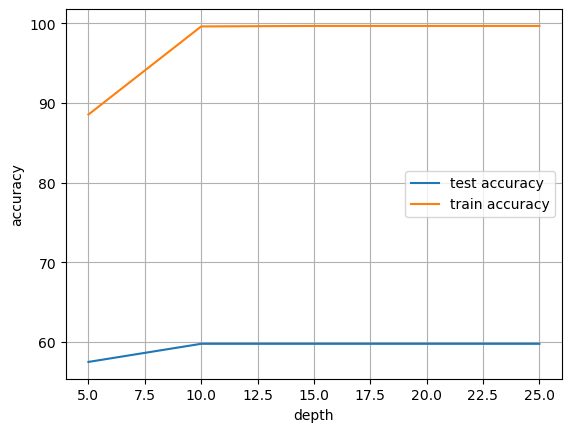

In [ ]:
plot_accuracies([test, train] , depths, ["test accuracy", "train accuracy"], "depth", "accuracy", "1.a)")

In [ ]:
# all win predictor, all loss predictor 
all_win_predictions = [1] * X_train.shape[0] 
all_loss_predictions = [0] * X_train.shape[0]
print(f"all win accuracy for train is {decision_tree_classifier.compute_accuracy(all_win_predictions, Y_train)}")
print(f"all loss accuracy for train is {decision_tree_classifier.compute_accuracy(all_loss_predictions, Y_train)}")

all_win_predictions = [1] * X_test.shape[0] 
all_loss_predictions = [0] * X_test.shape[0]
print(f"all win accuracy for test is {decision_tree_classifier.compute_accuracy(all_win_predictions, Y_test)}")
print(f"all loss accuracy test is {decision_tree_classifier.compute_accuracy(all_loss_predictions, Y_test)}")


all win accuracy for train is 0.5033857161108982
all loss accuracy for train is 0.49661428388910184
all win accuracy for test is 0.4963805584281282
all loss accuracy test is 0.5036194415718718


# One hot encoding

In [8]:
def get_np_array2(file_name):
    global label_encoder
    label_encoder = None 
    data = pd.read_csv(file_name)
    
    need_label_encoding = ['team','host','opp','month', 'day_match']
    if(label_encoder is None):
        label_encoder = OneHotEncoder(sparse_output = False)
        label_encoder.fit(data[need_label_encoding])
    mapping = label_encoder.categories_ # list of arrays
    data_1 = pd.DataFrame(label_encoder.transform(data[need_label_encoding]), columns = label_encoder.get_feature_names_out())
    
    #merge the two dataframes
    dont_need_label_encoding =  ["year","toss","bat_first","format" ,"fow","score" ,"rpo" ,"result"]
    data_2 = data[dont_need_label_encoding]
    final_data = pd.concat([data_1, data_2], axis=1)
    
    X = final_data.iloc[:,:-1]
    y = final_data.iloc[:,-1:]
    return (X.to_numpy(), y.to_numpy(), mapping)


In [54]:
train_mapping = []
test_mapping = []
X_test, Y_test, test_mapping = get_np_array2("../data/test.csv") 
X_train, Y_train, train_mapping = get_np_array2("../data/train.csv") 

train_one_hot_encoding_mapping = [] 
for arr in train_mapping:
    for j in range(len(arr)) : 
        train_one_hot_encoding_mapping.append(np.array([0,1], dtype="int64"))
    
test_one_hot_encoding_mapping= [] 
for arr in test_mapping:
    for j in range(len(arr)) : 
        test_one_hot_encoding_mapping.append(np.array([0,1], dtype="int64"))

to_extend = [ np.array([], dtype="int64"), np.array([0,1], dtype="int64"), np.array([0,1], dtype="int64"), 
             np.array([0,1], dtype="int64"), np.array([], dtype="int64"), np.array([], dtype="int64"), 
             np.array([], dtype="int64")]
# train_mapping.extend( to_extend )
train_one_hot_encoding_mapping.extend(to_extend) 
test_one_hot_encoding_mapping.extend(to_extend)
print(len(train_one_hot_encoding_mapping), len(test_one_hot_encoding_mapping)) 
print(train_one_hot_encoding_mapping)
print(test_one_hot_encoding_mapping)
Y_test = Y_test[:,0]
print(Y_test)

79 79
[array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1],

In [10]:
validation_mapping = [] 
X_validation, Y_validation, validation_mapping = get_np_array2("../data/val.csv") 

validation_one_hot_encoding_mapping = [] 
for arr in validation_mapping:
    for j in range(len(arr)) : 
        validation_one_hot_encoding_mapping.append(np.array([0,1], dtype="int64"))
    
to_extend = [ np.array([], dtype="int64"), np.array([0,1], dtype="int64"), np.array([0,1], dtype="int64"), 
             np.array([0,1], dtype="int64"), np.array([], dtype="int64"), np.array([], dtype="int64"), 
             np.array([], dtype="int64")]
# train_mapping.extend( to_extend )
print(validation_mapping)

for arr, arr2 in zip(validation_mapping, train_mapping):
    assert(np.array_equal(arr,arr2)) 
validation_one_hot_encoding_mapping.extend(to_extend)
print(len(validation_one_hot_encoding_mapping))
print(len(train_one_hot_encoding_mapping))

[array(['afganistan', 'australia', 'bangladesh', 'bermuda', 'canada',
       'england', 'india', 'ireland', 'kenya', 'netherlands',
       'new_zealand', 'pakistan', 'scotland', 'south_africa', 'sri_lanka',
       'uae', 'usa', 'west_indis', 'zimbambave'], dtype=object), array(['australia', 'bangladesh', 'bermuda', 'canada', 'england', 'india',
       'ireland', 'kenya', 'malaysia', 'netherlands', 'new_zealand',
       'pakistan', 'scotland', 'south_africa', 'sri_lanka', 'uae', 'usa',
       'west_indis', 'zimbambave'], dtype=object), array(['afganistan', 'australia', 'bangladesh', 'bermuda', 'canada',
       'england', 'india', 'ireland', 'kenya', 'netherlands',
       'new_zealand', 'pakistan', 'scotland', 'south_africa', 'sri_lanka',
       'uae', 'usa', 'west_indis', 'zimbambave'], dtype=object), array(['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may',
       'nov', 'oct', 'sep'], dtype=object), array([0, 1, 2], dtype=int64)]
79
79


In [11]:
one_hot_encodng_types = [] 

for arr in test_mapping:
    for j in range(len(arr)) : 
        one_hot_encodng_types.append("cat") 

one_hot_encodng_types.extend(["cont","cat","cat","cat" ,"cont","cont" ,"cont"] )  

print(len(one_hot_encodng_types))

one_hot_encodng_classifier = DTTree() 
depths = [15,25,35,45,50,55] 
# depths = [] 
my_train = [] 
my_test = [] 
my_validation = [] 
for depth in depths:
    one_hot_encodng_classifier.fit(X_train, Y_train, one_hot_encodng_types,train_one_hot_encoding_mapping, depth) 
    print(f"depth is {depth}")
    
    predictions = one_hot_encodng_classifier(X_train, train_one_hot_encoding_mapping) 
    accuracy = one_hot_encodng_classifier.compute_accuracy(predictions, Y_train) 
    my_train.append(accuracy * 100)
    print(f"train accuracy is {accuracy}" ) 
    
    predictions = one_hot_encodng_classifier(X_test, test_one_hot_encoding_mapping) 
    accuracy = one_hot_encodng_classifier.compute_accuracy(predictions, Y_test) 
    my_test.append(accuracy * 100)
    print(f"test accuracy is {accuracy}" )
    
    predictions = one_hot_encodng_classifier(X_validation, train_one_hot_encoding_mapping) 
    accuracy = one_hot_encodng_classifier.compute_accuracy(predictions, Y_validation) 
    my_validation.append(accuracy * 100)
    print(f"validation accuracy is {accuracy}" )


79


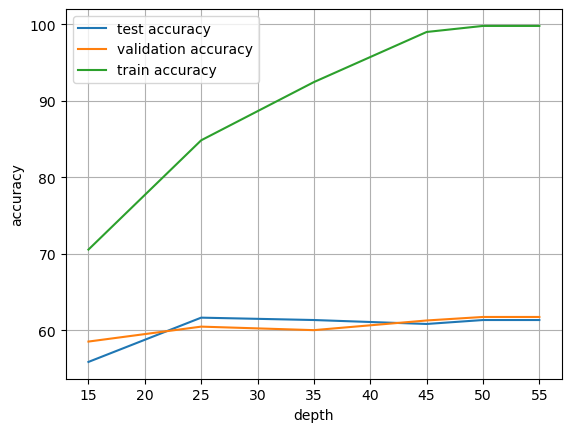

selected model is for depth 45, with test accuracy as 60.80661840744571


In [ ]:
# plot_accuracies(test, train, depths, "1.b)") 
# plotting all three accuracies
plot_accuracies([ my_test, my_validation, my_train] , depths, ["test accuracy", "validation accuracy", "train accuracy"], "depth", "accuracy", "1.b)")

validation = np.array(my_validation[:4])
depth = depths[np.argmax(validation)]
print(f"selected model is for depth {depth}, with test accuracy as {my_test[np.argmax(validation)]}")

### Comments 
1) train accuracies take a larger depth to reach 100 % than the previous case, since no of attributes has increased from 13 to 79 
2) test accuracies do not increase monotonically as was the case for part a, also they are more than test accuracies for part a. 

# Reduced Error pruning

In [43]:
class ReducedErrorDTTree(DTTree):
    def __init__(self):
        super().__init__() 

    
    def fit(self, X, y, validation_X, validation_y, types, mapping, max_depth = 10):
        self.type = types
        # self.x = self.convert_to_int(X)  
        self.x = X 
        self.y = y[:, 0]  # each element of y is a list 
        self.validation_x = validation_X 
        self.validation_y = validation_y[:, 0] 
        # print("y is ", self.y) 
        self.mapping = mapping 
        self.max_depth = max_depth

        self.root = self.grow_tree(self.x, self.y, 0) 
        self.no_of_nodes = self.count_nodes(self.root)
        print(self.no_of_nodes) 
        a,b,c,d = self.reduced_error_pruning() 
        print("training complete")
        return (a,b,c,d)   
    
    def find_next_prune(self):
        # finds (accuracy, best node) to prune to improve validation accuracy
        to_prune = queue.Queue() 
        to_prune.put(self.root) 
        best_acc = 0 
        best_node = None 
         
        while (not to_prune.empty()):
            node = to_prune.get() 
            if (node.is_leaf) : continue 
            node.is_leaf = True # pruning 
            predictions = self.__call__(self.validation_x, self.mapping) 
            acc = self.compute_accuracy(predictions, self.validation_y, False) 
            # assuming validation mapping to be same as train mapping 
            if (best_acc <= acc):
                best_acc = acc 
                best_node = node 
            
            node.is_leaf = False 
            
            for val,child in node.children:
                to_prune.put(child) 
        return (best_acc, best_node) 

    def reduced_error_pruning(self):
        init_predictions = self.__call__(self.validation_x, self.mapping) 
        init_accuracy = self.compute_accuracy(init_predictions, self.validation_y, False) 
        best_accuracy = init_accuracy
        current_accuracy = init_accuracy  
        new_node = None 
        cnt= 0 
        prev_leaves = self.count_leaves() 
        og_leaves = prev_leaves
        occ = 0 
        val_accs, train_accs, test_accs, no_of_nodes = [] , [], [], [] 
        while (occ <= 10 ):
            new_acc, new_node = self.find_next_prune() 
            new = self.count_leaves() 
            no_of_nodes.append(self.no_of_nodes - og_leaves + new)   
            current_accuracy = new_acc 
            val_accs.append(new_acc) 

            train_acc = self.compute_accuracy(self.__call__(self.x, self.mapping), self.y, False) 
            test_acc = self.compute_accuracy(self.__call__(X_test, self.mapping), Y_test, False)
            train_accs.append(train_acc)
            test_accs.append(test_acc)

            best_accuracy = max(best_accuracy, current_accuracy) 
            if (best_accuracy == current_accuracy):
                new_node.is_leaf = True 
                print(f"found better, accuracy is now {best_accuracy}" )
                if (prev_leaves - new == 1) : occ += 1 
                prev_leaves = new 
                cnt += 1 
            else :  break 
        print(f"pruning complete, pruned {cnt} nodes ") 
        # accs.reverse() 
        # no_of_nodes.reverse()
        val_accs.reverse()
        train_accs.reverse()
        test_accs.reverse()
        no_of_nodes.reverse()
        return (val_accs, train_accs, test_accs, no_of_nodes)
    
    def count_leaves(self):
        my_queue = queue.Queue() 
        my_queue.put(self.root) 
        cnt = 0 
        while (not my_queue.empty()):
            node = my_queue.get() 
            if (node.is_leaf) : cnt += 1 
            else:
                for val,child in node.children:
                    my_queue.put(child)
        print(f"no of leaves is {cnt}")
        return cnt 

In [79]:

reduced_error_classifier = ReducedErrorDTTree() 
depths = [15, 25,35,45] 
# depths = [15] 
# depths = [] 
train = [] 
test = [] 
validation = [] 

plot_validation, plot_train, plot_test, nodes = [], [], [], [] 

for depth in depths:
    val_accs, train_accs, test_accs, no_of_leaves = reduced_error_classifier.fit(X_train, Y_train,X_validation, Y_validation, one_hot_encodng_types,train_one_hot_encoding_mapping, depth) 
    plot_validation.append(val_accs) 
    plot_train.append(train_accs)
    plot_test.append(test_accs)
    nodes.append(no_of_leaves)
    
    print(f"depth is {depth}")
    
    predictions = reduced_error_classifier(X_train, train_one_hot_encoding_mapping) 
    accuracy = reduced_error_classifier.compute_accuracy(predictions, Y_train) 
    train.append(accuracy * 100)
    print(f"train accuracy is {accuracy}" ) 
    
    predictions = reduced_error_classifier(X_validation, train_one_hot_encoding_mapping) 
    accuracy = reduced_error_classifier.compute_accuracy(predictions, Y_validation) 
    validation.append(accuracy * 100)
    print(f"validation accuracy is {accuracy}" ) 


    predictions = reduced_error_classifier(X_test, test_one_hot_encoding_mapping) 
    accuracy = reduced_error_classifier.compute_accuracy(predictions, Y_test, False) 
    test.append(accuracy * 100)
    print(f"test accuracy is {accuracy}" )
    
    print() 

1557
no of leaves is 779
no of leaves is 779
found better, accuracy is now 0.5988505747126437
no of leaves is 729
found better, accuracy is now 0.6068965517241379
no of leaves is 520
found better, accuracy is now 0.6126436781609196
no of leaves is 405
found better, accuracy is now 0.6160919540229886
no of leaves is 404
found better, accuracy is now 0.6183908045977011
no of leaves is 403
found better, accuracy is now 0.6206896551724138
no of leaves is 402
found better, accuracy is now 0.6229885057471264
no of leaves is 400
found better, accuracy is now 0.6241379310344828
no of leaves is 399
found better, accuracy is now 0.6252873563218391
no of leaves is 398
found better, accuracy is now 0.6264367816091954
no of leaves is 397
found better, accuracy is now 0.6275862068965518
no of leaves is 396
found better, accuracy is now 0.628735632183908
no of leaves is 393
found better, accuracy is now 0.6298850574712643
no of leaves is 384
found better, accuracy is now 0.6310344827586207
no of leav

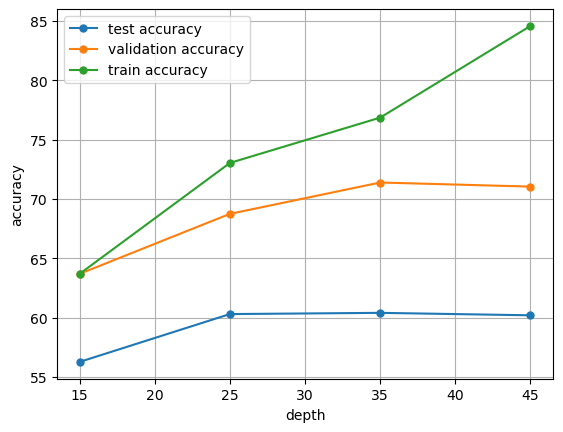

selected model is for depth 35, with test accuracy as 60.39296794208894


In [45]:
# plotting all three accuracies
depths = [15,25,35,45]

plot_accuracies([test, validation, train] , depths, ["test accuracy", "validation accuracy", "train accuracy"], "depth", "accuracy", "1.c.depth")

validation = np.array(validation)
depth = depths[np.argmax(validation)]
print(f"selected model is for depth {depth}, with test accuracy as {test[np.argmax(validation)]}")

[0.6367816091954023, 0.6367816091954023, 0.6367816091954023, 0.635632183908046, 0.6344827586206897, 0.6333333333333333, 0.632183908045977, 0.6310344827586207, 0.6298850574712643, 0.628735632183908, 0.6275862068965518, 0.6264367816091954, 0.6252873563218391, 0.6241379310344828, 0.6229885057471264, 0.6206896551724138, 0.6183908045977011, 0.6160919540229886, 0.6126436781609196, 0.6068965517241379, 0.5988505747126437]
[1140, 1141, 1142, 1143, 1144, 1146, 1157, 1162, 1171, 1174, 1175, 1176, 1177, 1178, 1180, 1181, 1182, 1183, 1298, 1507, 1557]


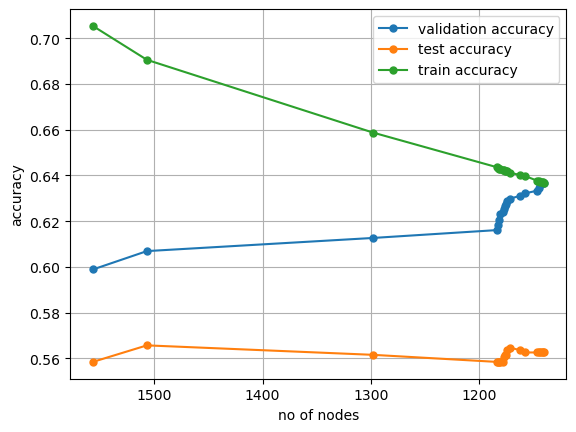

[2498, 2499, 2500, 2502, 2535, 2540, 2552, 2553, 2555, 2556, 2565, 2573, 2575, 2581, 2589, 2599, 2602, 2603, 2605, 2610, 2611, 2612, 2613, 2615, 2627, 2662, 2666, 2685, 2686, 2691, 2698, 2704, 2705, 2728, 2754, 2755, 2833, 3119, 3369]


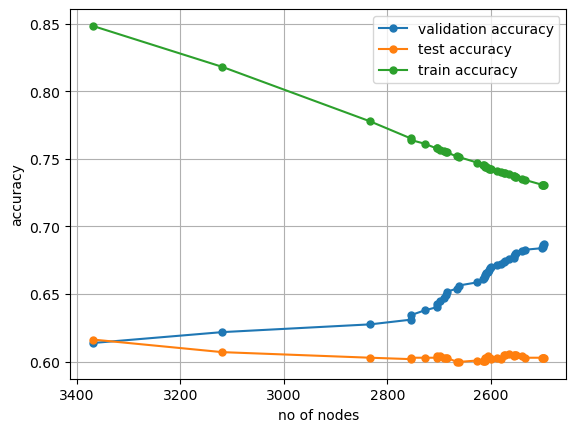

[3278, 3279, 3280, 3281, 3283, 3316, 3321, 3333, 3334, 3336, 3337, 3346, 3354, 3356, 3362, 3370, 3373, 3374, 3383, 3385, 3397, 3398, 3402, 3404, 3406, 3409, 3412, 3415, 3417, 3418, 3419, 3420, 3422, 3434, 3469, 3473, 3492, 3493, 3498, 3513, 3520, 3527, 3536, 3541, 3564, 3590, 3623, 3698, 3710, 3752, 4038, 4141, 4391]


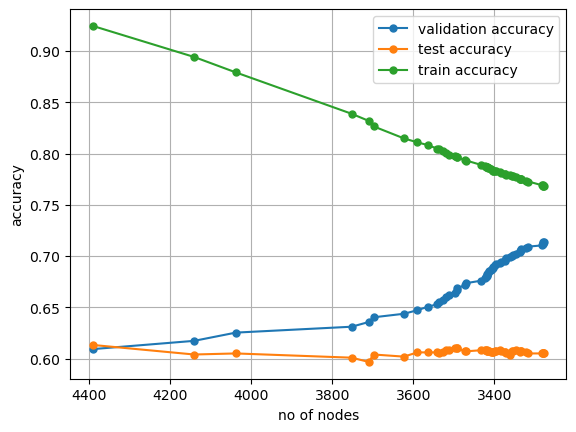

[4387, 4388, 4389, 4392, 4413, 4414, 4415, 4416, 4421, 4427, 4428, 4429, 4430, 4431, 4433, 4445, 4480, 4484, 4503, 4504, 4509, 4524, 4531, 4538, 4547, 4552, 4565, 4574, 4575, 4598, 4624, 4677, 4686, 4709, 4784, 5070, 5173, 5423]


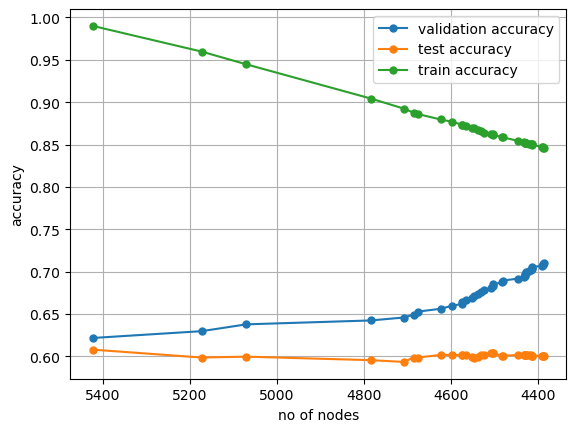

In [80]:
# nodes[0].reverse() 
print(plot_validation[0]) 
for i in range(4):
    print(nodes[i])
    plot_accuracies([plot_validation[i], plot_test[i], plot_train[i]] , nodes[i], ["validation accuracy", "test accuracy", "train accuracy"], "no of nodes", "accuracy", f"1.c.{depths[i]}")

### Sklearn model

In [14]:
from sklearn import tree 

In [15]:
# plotting against depth
depths = [15, 25, 35, 45]
depth_train = [] 
depth_test = [] 
depth_validation = [] 
decision_tree_classifier = DTTree() 
for depth in depths:
    sklearn_dt = tree.DecisionTreeClassifier(criterion="entropy", max_depth= depth)
    sklearn_dt.fit(X_train, Y_train)

    print(f"depth is {depth}")
    predictions = sklearn_dt.predict(X_test) 
    accuracy = decision_tree_classifier.compute_accuracy(predictions, Y_test )
    print(f"test accuracy is {accuracy}")
    depth_test.append(accuracy * 100)

    predictions = sklearn_dt.predict(X_train) 
    accuracy = decision_tree_classifier.compute_accuracy(predictions, Y_train )
    print(f"train accuracy is {accuracy}")
    depth_train.append(accuracy * 100)

    predictions = sklearn_dt.predict(X_validation) 
    accuracy = decision_tree_classifier.compute_accuracy(predictions, Y_validation )
    print(f"validation accuracy is {accuracy}")
    depth_validation.append(accuracy * 100)

depth is 15
test accuracy is 0.6070320579110652
train accuracy is 0.7134278778586942
validation accuracy is 0.5816091954022988
depth is 25
test accuracy is 0.6277145811789038
train accuracy is 0.8548613772837613
validation accuracy is 0.6045977011494252
depth is 35
test accuracy is 0.6535677352637022
train accuracy is 0.9437843362718794
validation accuracy is 0.6114942528735632
depth is 45
test accuracy is 0.6318510858324715
train accuracy is 0.9950172479877347
validation accuracy is 0.6206896551724138


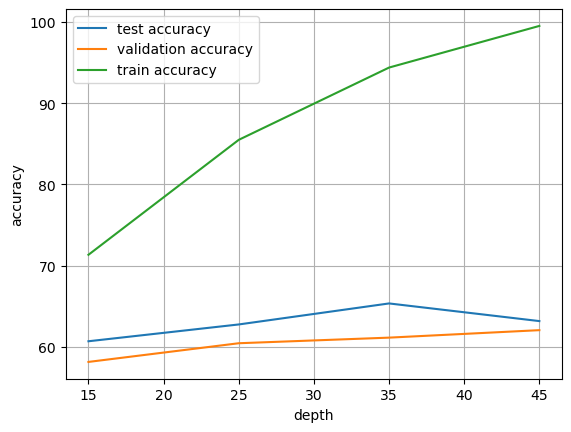

selected model is for depth 45, with test accuracy as 63.18510858324715


In [18]:
# plotting all three accuracies

plot_accuracies([depth_test, depth_validation, depth_train] , depths, ["test accuracy", "validation accuracy", "train accuracy"], "depth", "accuracy", "1.d.depth")

validation = np.array(depth_validation)
depth = depths[np.argmax(validation)]
print(f"selected model is for depth {depth}, with test accuracy as {depth_test[np.argmax(validation)]}")

Observe that when validation accuracy is maximum, test accuracy is also maximum. Thus selected model (depth 45) performs best on the test set. 
Based on validation accuracies, our model selected is for depth 35 and test accuracy is 60.81 %, whereas scikit's model is for depth 45, and test accuracy is 63.18 %, an improvement of 2.37 % . 


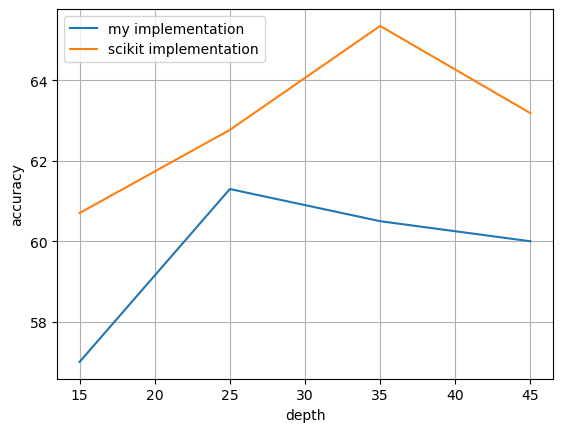

In [22]:
# comparison between my implmentation and scikit model 
my_test = [ 57, 61.3, 60.5, 60, 60.4 ]
plot_accuracies([my_test[:4], depth_test], depths, ["my implementation", "scikit implementation"], "depth", "accuracy", "1.d.comparision_depth_wise")


In [20]:
# plotting against ccp_alpha
alphas = [0.0001, 0.0005, 0.001, 0.01, 0.1, 0.2]
alpha_train = [] 
alpha_test = [] 
alpha_validation = [] 
for alpha in alphas:
    sklearn_dt = tree.DecisionTreeClassifier(criterion="entropy", ccp_alpha=alpha)
    sklearn_dt.fit(X_train, Y_train)

    print(f"alpha is {alpha}")
    predictions = sklearn_dt.predict(X_test) 
    accuracy = decision_tree_classifier.compute_accuracy(predictions, Y_test )
    print(f"test accuracy is {accuracy}")
    alpha_test.append(accuracy * 100)

    predictions = sklearn_dt.predict(X_train) 
    accuracy = decision_tree_classifier.compute_accuracy(predictions, Y_train )
    print(f"train accuracy is {accuracy}")
    alpha_train.append(accuracy * 100)

    predictions = sklearn_dt.predict(X_validation) 
    accuracy = decision_tree_classifier.compute_accuracy(predictions, Y_validation )
    print(f"validation accuracy is {accuracy}")
    alpha_validation.append(accuracy * 100)

alpha is 0.0001
test accuracy is 0.6525336091003102
train accuracy is 1.0
validation accuracy is 0.6252873563218391
alpha is 0.0005
test accuracy is 0.6752843846949328
train accuracy is 0.8411907499680593
validation accuracy is 0.6551724137931034
alpha is 0.001
test accuracy is 0.6628748707342296
train accuracy is 0.6894084579021337
validation accuracy is 0.632183908045977
alpha is 0.01
test accuracy is 0.5180972078593589
train accuracy is 0.5344320940334739
validation accuracy is 0.5
alpha is 0.1
test accuracy is 0.4963805584281282
train accuracy is 0.5033857161108982
validation accuracy is 0.4735632183908046
alpha is 0.2
test accuracy is 0.4963805584281282
train accuracy is 0.5033857161108982
validation accuracy is 0.4735632183908046


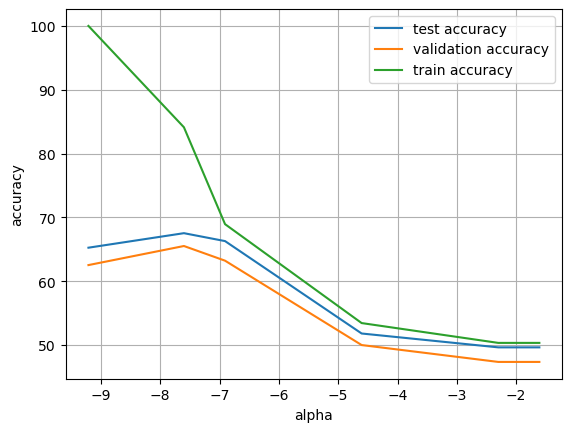

selected model is for alpha 0.0005, with test accuracy as 67.52843846949328


In [21]:
# plotting all three accuracies for alphas

plot_accuracies([alpha_test, alpha_validation, alpha_train] , np.log(np.array(alphas)), ["test accuracy", "validation accuracy", "train accuracy"], "alpha", "accuracy", "1.d.alpha")


validation = np.array(alpha_validation)
alpha = alphas[np.argmax(validation)]
print(f"selected model is for alpha {alpha}, with test accuracy as {alpha_test[np.argmax(validation)]}")

### Random Forests 

In [ ]:
from sklearn.ensemble import RandomForestClassifier 

In [ ]:
# experimenting with no_of_estimators 
# using n_jobs to speed up 
n_estimators = np.arange(50, 400, 100) 
rf_oob = [] 
rf_test, rf_train, rf_val = [], [], [] 
for n in n_estimators:
    print(f"n is {n}")
    random_forest_classifier = RandomForestClassifier(n_estimators=n, n_jobs= n, oob_score=True) 
    random_forest_classifier = random_forest_classifier.fit(X_train, Y_train[:, 0]) 
    print(f"oob accuracy is {random_forest_classifier.oob_score_}") 
    rf_oob.append(random_forest_classifier.oob_score_ * 100) 

    predictions = random_forest_classifier.predict(X_train) 
    accuracy = reduced_error_classifier.compute_accuracy(predictions, Y_train[:, 0], False) 
    print(f"train accuracy is {accuracy}") 
    rf_train.append(accuracy * 100)

    predictions = random_forest_classifier.predict(X_test) 
    accuracy = reduced_error_classifier.compute_accuracy(predictions, Y_test[:, 0], False) 
    print(f"test accuracy is {accuracy}") 
    rf_test.append(accuracy * 100)

    predictions = random_forest_classifier.predict(X_validation) 
    accuracy = reduced_error_classifier.compute_accuracy(predictions, Y_validation[:, 0], False) 
    print(f"validation accuracy is {accuracy}") 
    rf_val.append(accuracy * 100)



n is 50
oob accuracy is 0.6877475405647119
train accuracy is 0.9998722371278906
test accuracy is 0.6928645294725957
validation accuracy is 0.6793103448275862
n is 150
oob accuracy is 0.6978408074613517
train accuracy is 1.0
test accuracy is 0.6856256463288521
validation accuracy is 0.674712643678161
n is 250
oob accuracy is 0.6978408074613517
train accuracy is 1.0
test accuracy is 0.6814891416752844
validation accuracy is 0.6758620689655173
n is 350
oob accuracy is 0.6988629104382267
train accuracy is 1.0
test accuracy is 0.6959669079627715
validation accuracy is 0.6804597701149425


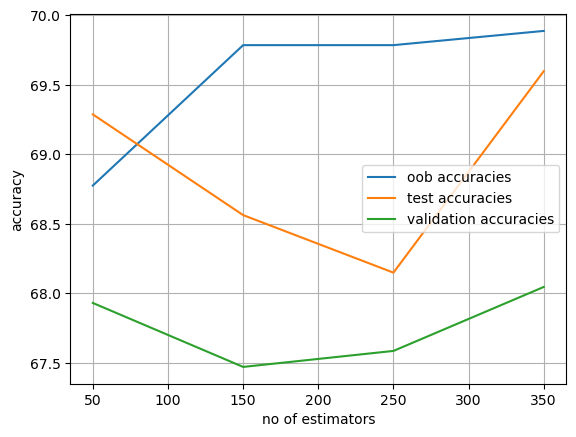

In [ ]:
#omitting train accuracies as they are 100 % 
y_lines = np.array([np.array(rf_oob), np.array(rf_test), np.array(rf_val)]) 
labels = ["oob accuracies", "test accuracies", "validation accuracies"] 

plot_accuracies(y_lines, n_estimators, labels, "no of estimators", "accuracy", "1.e.n_estimator") 

In [ ]:
# max_Features 
max_features = np.arange(0.1, 1.2, 0.2) 
def tr(x) : return min(1,x) 
max_features = np.vectorize(tr)(max_features) 
# max_features = [1.0]
mf_oob, mf_train, mf_test, mf_val = [],[],[],[] 

for mf in max_features:
    print(f"mf is {mf}")
    random_forest_classifier = RandomForestClassifier(n_jobs= 100 , max_features=mf, oob_score=True) 
    random_forest_classifier = random_forest_classifier.fit(X_train, Y_train[:, 0]) 
    print(f"oob accuracy is {random_forest_classifier.oob_score_}") 
    mf_oob.append(random_forest_classifier.oob_score_ * 100) 

    predictions = random_forest_classifier.predict(X_train) 
    accuracy = reduced_error_classifier.compute_accuracy(predictions, Y_train[:, 0], False) 
    print(f"train accuracy is {accuracy}") 
    mf_train.append(accuracy * 100)

    predictions = random_forest_classifier.predict(X_test) 
    accuracy = reduced_error_classifier.compute_accuracy(predictions, Y_test[:, 0], False) 
    print(f"test accuracy is {accuracy}") 
    mf_test.append(accuracy * 100)

    predictions = random_forest_classifier.predict(X_validation) 
    accuracy = reduced_error_classifier.compute_accuracy(predictions, Y_validation[:, 0], False) 
    print(f"validation accuracy is {accuracy}") 
    mf_val.append(accuracy * 100)

mf is 0.1
oob accuracy is 0.691963715344321
train accuracy is 1.0
test accuracy is 0.6866597724922441
validation accuracy is 0.6689655172413793
mf is 0.30000000000000004
oob accuracy is 0.7065286827647885
train accuracy is 1.0
test accuracy is 0.7001034126163392
validation accuracy is 0.6896551724137931
mf is 0.5000000000000001
oob accuracy is 0.7094672288233039
train accuracy is 1.0
test accuracy is 0.7094105480868665
validation accuracy is 0.7
mf is 0.7000000000000001
oob accuracy is 0.7092117030790852
train accuracy is 1.0
test accuracy is 0.7197518097207859
validation accuracy is 0.7080459770114943
mf is 0.9000000000000001
oob accuracy is 0.7103615689280695
train accuracy is 1.0
test accuracy is 0.7135470527404343
validation accuracy is 0.7034482758620689
mf is 1.0
oob accuracy is 0.7083173629743197
train accuracy is 1.0
test accuracy is 0.718717683557394
validation accuracy is 0.6919540229885057


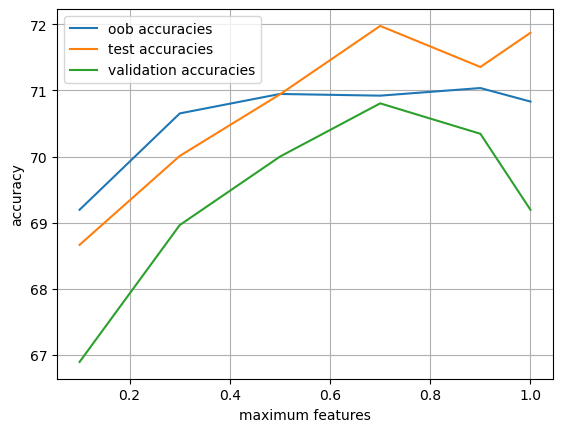

In [ ]:
y_lines = np.array([np.array(mf_oob), np.array(mf_test), np.array(mf_val)]) 
labels = ["oob accuracies", "test accuracies", "validation accuracies"] 

plot_accuracies(y_lines, max_features, labels, "maximum features", "accuracy", "1.e.max_features")

In [ ]:
# min_split 
min_split = np.arange(2, 12, 2 ) 
ms_oob, ms_train, ms_test, ms_val = [],[],[],[] 

for ms in min_split:
    print(f"ms is {ms}")
    random_forest_classifier = RandomForestClassifier( n_jobs= 100 , min_samples_split= ms,  oob_score=True) 
    random_forest_classifier = random_forest_classifier.fit(X_train, Y_train[:, 0]) 
    print(f"oob accuracy is {random_forest_classifier.oob_score_}") 
    ms_oob.append(random_forest_classifier.oob_score_ * 100) 

    predictions = random_forest_classifier.predict(X_train) 
    accuracy = reduced_error_classifier.compute_accuracy(predictions, Y_train[:, 0], False) 
    print(f"train accuracy is {accuracy}") 
    ms_train.append(accuracy * 100)

    predictions = random_forest_classifier.predict(X_test) 
    accuracy = reduced_error_classifier.compute_accuracy(predictions, Y_test[:, 0], False) 
    print(f"test accuracy is {accuracy}") 
    ms_test.append(accuracy * 100)

    predictions = random_forest_classifier.predict(X_validation) 
    accuracy = reduced_error_classifier.compute_accuracy(predictions, Y_validation[:, 0], False) 
    print(f"validation accuracy is {accuracy}") 
    ms_val.append(accuracy * 100)

ms is 2
oob accuracy is 0.6934968698096333
train accuracy is 1.0
test accuracy is 0.6949327817993796
validation accuracy is 0.6827586206896552
ms is 4
oob accuracy is 0.6932413440654146
train accuracy is 0.9911843618244538
test accuracy is 0.6918304033092038
validation accuracy is 0.6977011494252874
ms is 6
oob accuracy is 0.7075507857416635
train accuracy is 0.9704867765427366
test accuracy is 0.6959669079627715
validation accuracy is 0.6816091954022988
ms is 8
oob accuracy is 0.6977130445892423
train accuracy is 0.9518333972147693
test accuracy is 0.6825232678386763
validation accuracy is 0.6793103448275862
ms is 10
oob accuracy is 0.702823559473617
train accuracy is 0.9359908010732081
test accuracy is 0.6918304033092038
validation accuracy is 0.6896551724137931


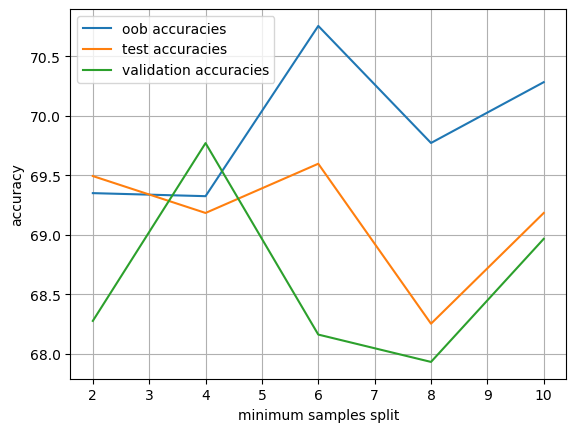

In [ ]:
y_lines = np.array([np.array(ms_oob), np.array(ms_test), np.array(ms_val)]) 
labels = ["oob accuracies", "test accuracies", "validation accuracies"] 

plot_accuracies(y_lines, min_split, labels, "minimum samples split", "accuracy", "1.e.min_sample_split")

#### Initial Comments
1. on increasing number of estimators, we observe that oob accuracies overall increase from 68.7 at no of estimators 50 to a maximum of 70.5 at no of estimators 750, but after a certain threshold (250), the increase is nominal and accuracies tend to stabilise . 

2. Almost the same trend is observed for max_features for oob accuracies, increasing from 68.2 % at 0.1 to about 71 % at 0.7 . 

3. oob accuracies improve from 69 % to about 70.5 %. 

### Grid Search

In [ ]:
from sklearn.model_selection import ParameterGrid 

In [ ]:
param_grid = {"n_estimators" : n_estimators, "min_samples_split" : min_split, "max_features" : max_features}
param_grid = ParameterGrid(param_grid) 

grid_search_rf = RandomForestClassifier(n_jobs=100, oob_score=True)  

best_model_test = None
best_model_oob = None 
best_oob = -1
best_test = -1 
for param in param_grid:
    print(param)
    grid_search_rf.set_params(**param)
    grid_search_rf.fit(X_train, Y_train[:,0])  

    predictions = grid_search_rf.predict(X_test) 
    accuracy = reduced_error_classifier.compute_accuracy(predictions, Y_test) 
    print(f"test accuracy is {accuracy}") 
    
    if (accuracy > best_test):
        best_test = accuracy 
        best_model_test = param 
    
    oob_score = grid_search_rf.oob_score_ 
    print(f"oob score is {oob_score}") 
    if (oob_score > best_oob):
        best_oob = oob_score 
        best_model_oob = param 
    

print(f"best parameters for oob are {best_model_oob}, with oob score as {best_oob}")
print(f"best params for test acc are {best_model_test}, with test score as {best_test}") 



{'max_features': 0.1, 'min_samples_split': 2, 'n_estimators': 50}
test accuracy is 0.6970010341261634
oob score is 0.6791874281333844
{'max_features': 0.1, 'min_samples_split': 2, 'n_estimators': 150}
test accuracy is 0.6814891416752844
oob score is 0.6954133128912738
{'max_features': 0.1, 'min_samples_split': 2, 'n_estimators': 250}
test accuracy is 0.6970010341261634
oob score is 0.6984796218218986
{'max_features': 0.1, 'min_samples_split': 2, 'n_estimators': 350}
test accuracy is 0.6783867631851086
oob score is 0.6980963332055704
{'max_features': 0.1, 'min_samples_split': 4, 'n_estimators': 50}
test accuracy is 0.6845915201654602
oob score is 0.6837868915293216
{'max_features': 0.1, 'min_samples_split': 4, 'n_estimators': 150}
test accuracy is 0.6907962771458118
oob score is 0.6988629104382267
{'max_features': 0.1, 'min_samples_split': 4, 'n_estimators': 250}
test accuracy is 0.6970010341261634
oob score is 0.7060176312763511
{'max_features': 0.1, 'min_samples_split': 4, 'n_estimato

In [ ]:
print(best_model_oob)
grid_search_rf.set_params(**best_model_oob)
grid_search_rf.fit(X_train, Y_train[:,0]) 

predictions = grid_search_rf.predict(X_train) 
accuracy = reduced_error_classifier.compute_accuracy(predictions, Y_train) 
print(f"train accuracy is {accuracy}") 

predictions = grid_search_rf.predict(X_test) 
accuracy = reduced_error_classifier.compute_accuracy(predictions, Y_test) 
print(f"test accuracy is {accuracy}") 

predictions = grid_search_rf.predict(X_validation) 
accuracy = reduced_error_classifier.compute_accuracy(predictions, Y_validation) 
print(f"validation accuracy is {accuracy}") 


print(f"oob accuracy is {grid_search_rf.oob_score_}") 

{'max_features': 0.9000000000000001, 'min_samples_split': 10, 'n_estimators': 350}
train accuracy is 0.9703590136706273
test accuracy is 0.7300930713547052
validation accuracy is 0.7114942528735633
oob accuracy is 0.7204548358247094


### Comments
Test, validation, and train accuracies for part d are 67.5, 65.5, 84.3 for ccp_alpha; and 63.9, 62.3 and 99.5 for depth. whereas the same for part c are 60.5, 71.3 and 76.8 % 

Using random forests with grid search we obtain 73.6, 70.9 and 97 %. 

We observe that the test set accuracy is the highest for rf with grid search by quite a large margin (nearest accuracy is 67.5, lower by 5.9 %), whereas the validation acc is highest for our reduced error pruning model. The train accuracy is highest for the scikit decision tree classifier. The most probable reason for high test set accuracy for rf is the absence of overfitting in it. The scikit model most probably overfits, thus its train accuracy is highest. Our reduced error pruning model was based on improving validation accuracy, thus it makes sense for it having the highest validation accuracy. 